In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
# Set an option to display all rows/columns without shortening them
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('Order_Transaction_Master.csv')

In [3]:
#copy the orignal data(df) to a copy data(df_1)
df_1 = df.copy()

In [4]:
df_1.head()

,Order_ID,Customer_ID,Order_Date,Order_Status,Total_Amount_USD,Total_Items_Count,Payment_Method,Shipping_Type,Shipping_Cost_USD,Coupon_Code_Used,...,Product_Returns__Apparel_91,Customer_Service_Contact__Apparel_92,Order_Refunded_Flag__Electronics_93,Payment_Transaction_Fee__Regional_94,Customer_Service_Contact__Priority_95,Payment_Transaction_Fee__ReturnsPolicy_96,Order_Refunded_Flag__Priority_97,Warehouse_Location_Code__Electronics_98,Order_Refunded_Flag__Regional_99,Time_to_Payment_Confirmation__Regional_100
0,ORD00000001,CUST015796,2024-12-09 00:04:32,Completed,134.30,4,Credit Card,Economy,4.00,NONE,...,0,0,0,0.0295,0,0.0262,0,1,0,3.0145
1,ORD00000002,CUST000861,2024-09-04 22:54:57,Shipped,2001.87,2,Digital Wallet,Standard,7.74,FREESHIP,...,0,0,0,0.0208,0,0.0153,0,4,0,0.8283
2,ORD00000003,CUST076821,2024-11-22 10:26:33,Completed,233.57,1,PayPal,Standard,5.67,NONE,...,0,1,0,0.0092,1,0.0100,0,13,0,3.5616
3,ORD00000004,CUST054887,2024-06-15 16:11:54,Shipped,300.11,5,PayPal,Express,0.75,NONE,...,0,0,0,0.0278,0,0.0212,0,10,0,2.5930
4,ORD00000005,CUST006266,2024-05-04 21:55:03,Completed,536.28,3,Credit Card,Express,14.16,NONE,...,0,0,0,0.0161,0,0.0143,0,4,0,2.9948


In [5]:
#we removed all unnecessary columns
columns_to_keep = ['Customer_ID', 'Order_Date', 'Total_Amount_USD']
new_df = df[columns_to_keep]

In [6]:
new_df.head()

,Customer_ID,Order_Date,Total_Amount_USD
0,CUST015796,2024-12-09 00:04:32,134.30
1,CUST000861,2024-09-04 22:54:57,2001.87
2,CUST076821,2024-11-22 10:26:33,233.57
3,CUST054887,2024-06-15 16:11:54,300.11
4,CUST006266,2024-05-04 21:55:03,536.28


In [7]:
#cheaking null values
new_df.isnull().sum()

Customer_ID         0
Order_Date          0
Total_Amount_USD    0
dtype: int64

In [8]:
new_df.shape

(100000, 3)

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       100000 non-null  object 
 1   Order_Date        100000 non-null  object 
 2   Total_Amount_USD  100000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB


In [10]:
#changing Order Date(object) to date time
new_df['Order_Date'] = pd.to_datetime(new_df['Order_Date'])

C:\Users\mafin\AppData\Local\Temp\ipykernel_12304\301475436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Order_Date'] = pd.to_datetime(new_df['Order_Date'])


In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Customer_ID       100000 non-null  object        
 1   Order_Date        100000 non-null  datetime64[ns]
 2   Total_Amount_USD  100000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.3+ MB


# 1. RFM

In [12]:
# 1. Define the snapshot date for recency calculation
snapshot_date = new_df['Order_Date'].max() + dt.timedelta(days=1)

# 2. Group by customer and calculate R, F, and M values
rfm_df = new_df.groupby('Customer_ID').agg({
    'Order_Date': 'count',  # <-- CHANGE THIS LINE to calculate frequency
    'Total_Amount_USD': 'sum'
}).reset_index()

# Calculate Recency separately
recency_df = new_df.groupby('Customer_ID')['Order_Date'].max().reset_index()
recency_df['Recency'] = (snapshot_date - recency_df['Order_Date']).dt.days

# Merge recency with the main rfm_df
rfm_df = pd.merge(rfm_df, recency_df[['Customer_ID', 'Recency']], on='Customer_ID')

# 3. Rename the columns to Recency, Frequency, and Monetary
rfm_df.rename(columns={'Order_Date': 'Frequency',
                       'Total_Amount_USD': 'Monetary'}, inplace=True)

# Reorder columns for clarity
rfm_df = rfm_df[['Customer_ID', 'Recency', 'Frequency', 'Monetary']]

# --- Display the Result ---
print("RFM DataFrame Head:")
print(rfm_df.head())

RFM DataFrame Head:
  Customer_ID  Recency  Frequency  Monetary
0  CUST000002      100          1   2472.46
1  CUST000003       15          4    536.27
2  CUST000006        6          3    484.11
3  CUST000007      608          1    623.95
4  CUST000008      585          1   1026.06


In [13]:
rfm_df.shape

(63217, 4)

In [14]:
# Get the amount of the most recent transaction for each customer
last_transaction_details = new_df.loc[new_df.groupby('Customer_ID')['Order_Date'].idxmax()]

# Merge last transaction details with your existing RFM dataframe
final_df = pd.merge(
    rfm_df,  # from your first code
    last_transaction_details[['Customer_ID', 'Order_Date', 'Total_Amount_USD']],
    on='Customer_ID',
    how='left'
)

# Rename columns for clarity
final_df.rename(columns={'Order_Date': 'Last_Order_Date',
                         'Total_Amount_USD': 'Last_Transaction_Amount'}, inplace=True)

# Reorder columns if needed
final_df = final_df[['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'Last_Order_Date', 'Last_Transaction_Amount']]

# Display the final dataframe
final_df.head()


,Customer_ID,Recency,Frequency,Monetary,Last_Order_Date,Last_Transaction_Amount
0,CUST000002,100,1,2472.46,2025-07-01 15:52:16,2472.46
1,CUST000003,15,4,536.27,2025-09-25 02:13:59,33.33
2,CUST000006,6,3,484.11,2025-10-03 12:46:32,24.83
3,CUST000007,608,1,623.95,2024-02-10 09:15:17,623.95
4,CUST000008,585,1,1026.06,2024-03-03 21:15:41,1026.06


In [15]:
final_df.shape

(63217, 6)

In [16]:
# RFM Scoring (1–5)
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = better
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Combine all scores
rfm_df['RFM_Score'] = (
    rfm_df['R_Score'].astype(int)
    + rfm_df['F_Score'].astype(int)
    + rfm_df['M_Score'].astype(int)
)

# Define segmentation logic
def segment_customer(score):
    if score >= 13:
        return 'Champion'
    elif score >= 10:
        return 'Loyal'
    elif score >= 7:
        return 'Potential'
    elif score >= 4:
        return 'At-Risk'
    else:
        return 'Lost'

# Apply segmentation
rfm_df['Segment'] = rfm_df['RFM_Score'].apply(segment_customer)

# Summarize by segment
segment_summary = rfm_df.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Define the desired order for display
order = ['Champion', 'Loyal', 'Potential', 'At-Risk', 'Lost']
segment_summary['Segment'] = pd.Categorical(segment_summary['Segment'], categories=order, ordered=True)

# Sort by defined order
segment_summary = segment_summary.sort_values('Segment')

print(segment_summary)


     Segment     Recency  Frequency     Monetary
1   Champion  107.380055   2.727095  1839.569724
3      Loyal  228.019430   1.886641  1016.373002
4  Potential  323.759394   1.180417   548.251635
0    At-Risk  492.549314   1.006548   197.448382
2       Lost  626.133607   1.000000    75.987361


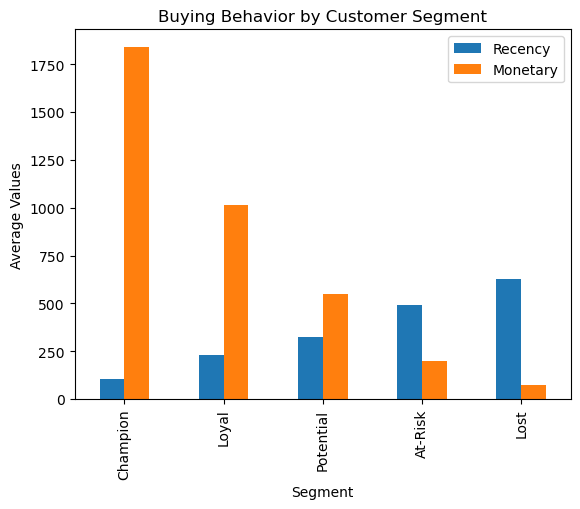

In [17]:
segment_summary.set_index('Segment')[['Recency','Monetary']].plot(kind='bar')
plt.title('Buying Behavior by Customer Segment')
plt.ylabel('Average Values')
plt.show()

In [18]:
# Calculate basic CLV metrics
clv_data = new_df.groupby('Customer_ID').agg({
    'Total_Amount_USD': ['sum', 'mean', 'count'],
    'Order_Date': ['min', 'max']
}).reset_index()

clv_data.columns = ['Customer_ID', 'Total_Spent', 'Avg_Order_Value', 'Total_Orders', 'First_Purchase', 'Last_Purchase']

# Calculate customer lifespan
clv_data['Lifespan_Days'] = (pd.to_datetime(clv_data['Last_Purchase']) - 
                            pd.to_datetime(clv_data['First_Purchase'])).dt.days
clv_data['Lifespan_Days'] = clv_data['Lifespan_Days'].replace(0, 1)  # Avoid division by zero

# Simple CLV calculation
clv_data['CLV'] = (clv_data['Total_Spent'] / clv_data['Lifespan_Days']) * 365  # Annualized

# Merge with RFM data
customer_analysis = pd.merge(rfm_df, clv_data[['Customer_ID', 'CLV', 'Total_Spent', 'Total_Orders']], 
                            on='Customer_ID', how='left')

clv_data.head()

,Customer_ID,Total_Spent,Avg_Order_Value,Total_Orders,First_Purchase,Last_Purchase,Lifespan_Days,CLV
0,CUST000002,2472.46,2472.4600,1,2025-07-01 15:52:16,2025-07-01 15:52:16,1,902447.900000
1,CUST000003,536.27,134.0675,4,2023-10-21 23:40:33,2025-09-25 02:13:59,704,278.037713
2,CUST000006,484.11,161.3700,3,2023-12-26 03:44:31,2025-10-03 12:46:32,647,273.106878
3,CUST000007,623.95,623.9500,1,2024-02-10 09:15:17,2024-02-10 09:15:17,1,227741.750000
4,CUST000008,1026.06,1026.0600,1,2024-03-03 21:15:41,2024-03-03 21:15:41,1,374511.900000


In [19]:
clv_data.shape

(63217, 8)

# Top 10 Customers by CLV

C:\Users\mafin\AppData\Local\Temp\ipykernel_12304\115444468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers, x='Customer_ID', y='CLV', palette='viridis')


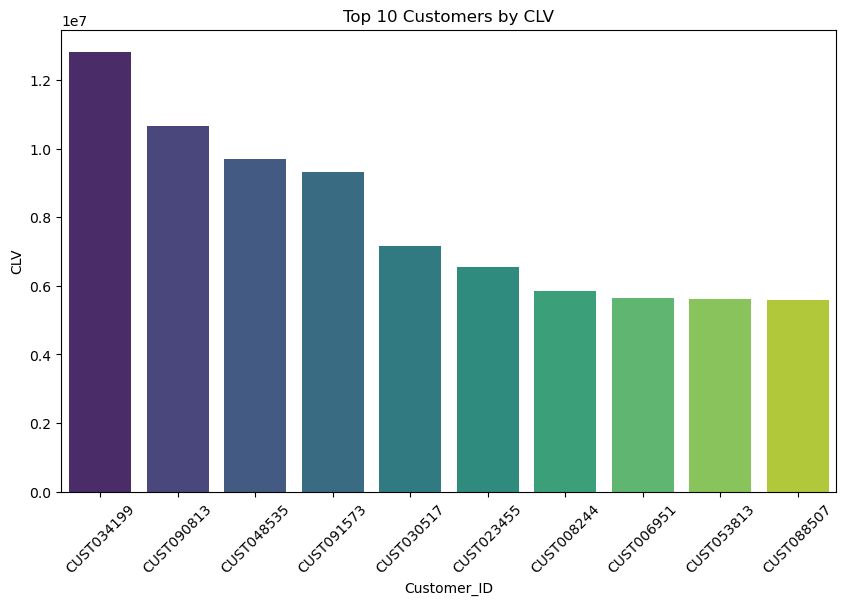

In [23]:
top_customers = clv_data.nlargest(10, 'CLV')

plt.figure(figsize=(10,6))
sns.barplot(data=top_customers, x='Customer_ID', y='CLV', palette='viridis')
plt.title('Top 10 Customers by CLV')
plt.xticks(rotation=45)
plt.show()


In [29]:
# Define the churn threshold in days (e.g., 6 months = ~180 days)
churn_threshold_days = 180

# Create a 'Churn' column. 1 if churned, 0 if active.
# A customer is considered churned if their last purchase was more than the threshold number of days ago.
rfm_df['Churn'] = rfm_df['Recency'].apply(lambda x: 1 if x > churn_threshold_days else 0)

# Analyze the average RFM values for churned vs. active customers
churn_analysis = rfm_df.groupby('Churn')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# To make the output clearer, let's rename the Churn values to descriptive labels
churn_analysis['Churn'] = churn_analysis['Churn'].map({0: 'Active', 1: 'Churned'})

print(f"Churn Definition: A customer is marked as 'Churned' if they have not made a purchase in over {churn_threshold_days} days.")
print("\\n--- Average RFM Metrics for Active vs. Churned Customers ---\\n")
print(churn_analysis.to_string(index=False))


Churn Definition: A customer is marked as 'Churned' if they have not made a purchase in over 180 days.
\n--- Average RFM Metrics for Active vs. Churned Customers ---\n
  Churn    Recency  Frequency   Monetary
 Active  86.795157   1.877537 955.695821
Churned 421.851939   1.427522 713.516270
